# H2A visas analysis

By [Ben Welsh](mailto:ben.welsh@latimes.com)

The Los Angeles Times conducted an analysis of temporary visas granted to foreign agricultural workers by the United States Department of Labor via its H2A program.

The results were reported in a May 25, 2017, Los Angeles Times story titled ["Foobar"]().

Here are the key findings of the data analysis, which is documented below:

* The total number of certified H2A visas is going up nationwide
* California's total topped 11,000 last year, a fivefold increase from 2011
* If this year’s hiring pace holds, that number will soar even higher
* Counties on the Central Coast, from Ventura up to Santa Cruz, are driving the growth
* Strawberries and lettuce crops have accounted for most of the new workers
* The Santa Maria Valley, straddling San Louis Obispo and Santa Barbara counties, leapt from six sheepherders in 2012 to more than 2,000 guest farm workers last year
* Strawberry workers account for most of the growth in that area

## How we did it

### Import Python analysis tools

In [159]:
import os
import pandas as pd
import geopandas as gp
from datetime import date
from shapely.geometry import Point

In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
pd.options.display.max_columns = None

In [38]:
%matplotlib inline

In [39]:
input_dir = os.path.join(os.getcwd(), 'input')
output_dir = os.path.join(os.getcwd(), 'output')

### Prepare the data for analysis

Download the source data files from the U.S. Department of Labor's [Office of Foreign Labor Certification](https://www.foreignlaborcert.doleta.gov/performancedata.cfm).

In [40]:
%%capture
%run 01_download.ipynb

Prepare them for analysis by carefully combining annual lists, winnowing out duplicate entries and limiting the result to approved applications.

In [41]:
%%capture
%run 02_transform.ipynb

Map work site locations

In [42]:
%%capture
run 03_geocode.ipynb

### Finding: The total number of certified H2A visas is going up nationwide

Read in the transformed file for analysis

In [101]:
df = pd.read_csv(
    os.path.join(output_dir, "transformed_master_cases.csv"),
    index_col="latimes_id",
)

Group by calendar year and sum the total number of certified workers

In [102]:
annual_usa = df.groupby("certification_start_year").agg(dict(workers_certified="sum"))

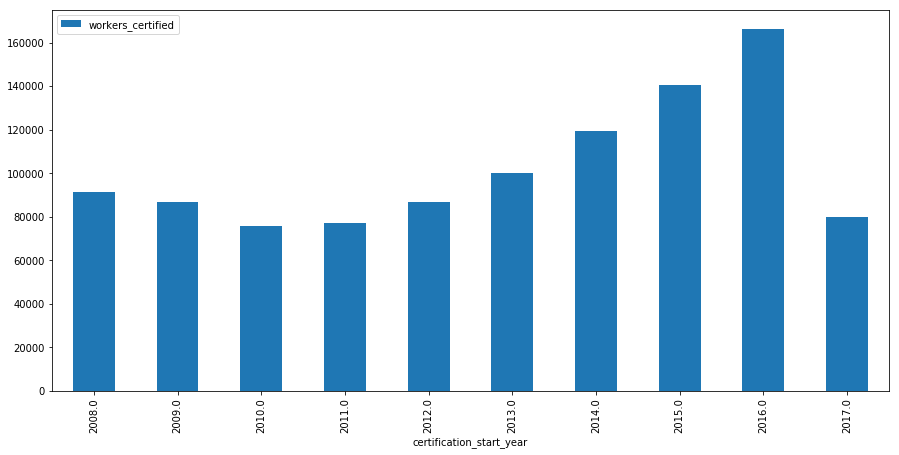

In [103]:
annual_usa.plot.bar(figsize=(15, 7))

In [104]:
annual_usa

,workers_certified
certification_start_year,
2008.0,91324
2009.0,86604
2010.0,75617
2011.0,77221
2012.0,86725
2013.0,100360
2014.0,119240
2015.0,140701
2016.0,166457


### Finding: California's total topped 11,000 last year, a fivefold increase from 2011

Group the applications by state and year

In [105]:
state_totals = df.groupby(['state', 'certification_start_year']).agg(dict(workers_certified="sum"))

Create a crosstab for a graphic and comparison

In [106]:
state_crosstab = state_totals.unstack(1).fillna(0)

Output it for a graphic

In [107]:
state_crosstab.to_csv("./output/state_crosstab.csv")

Filter down to just California's totals

In [108]:
ca_totals = state_totals[state_totals.index.get_level_values(0) == 'CA']

Ouput the annual totals

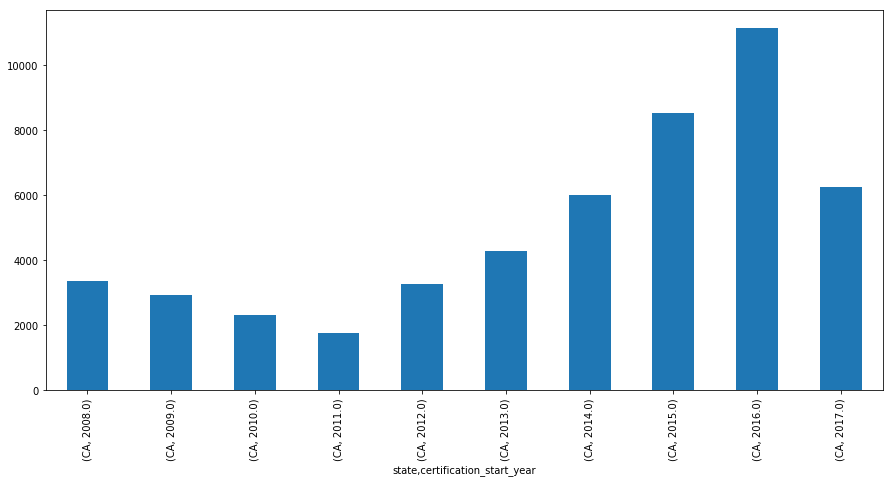

In [109]:
ca_totals.workers_certified.plot.bar(figsize=(15, 7))

In [110]:
ca_totals

workers_certified
state certification_start_year                   
CA    2008.0                                 3353
      2009.0                                 2941
      2010.0                                 2298
      2011.0                                 1774
      2012.0                                 3249
      2013.0                                 4291
      2014.0                                 6011
      2015.0                                 8529
      2016.0                                11131
      2017.0                                 6230

Trim down to the last five years of data and calculate California's percentage change

In [111]:
ca_last_five = ca_totals[
    (ca_totals.index.get_level_values(1) > 2010) &
    (ca_totals.index.get_level_values(1) < 2017)
].reset_index()

In [112]:
ca_pct_change = ca_last_five[[
  'certification_start_year',
  'workers_certified'
]].set_index('certification_start_year').pct_change(
    len(ca_last_five)-1
)

In [113]:
print "Percent change: %s%%" % round(ca_pct_change.at[2016.0, 'workers_certified']*100, 2)

Percent change: 527.45%


Output for a graphic

In [114]:
ca_totals.reset_index()[['certification_start_year', 'workers_certified']].to_csv(
    "./output/california-totals-graphics.csv",
    index=False
)

### Finding: If this year’s hiring pace holds, that number will soar even higher

Convert the start date column to a datetime object

In [158]:
df.certification_start_date = pd.to_datetime(df.certification_start_date)

Pull out the first four months of this year versus last year

In [169]:
first_four_16 = df[
    (df.state == 'CA') &
    (df.certification_start_date >= date(2016, 1, 1)) & 
    (df.certification_start_date < date(2016, 5, 1))
]

In [170]:
first_four_17 = df[
    (df.state == 'CA') &
    (df.certification_start_date >= date(2017, 1, 1)) & 
    (df.certification_start_date < date(2017, 5, 1))
]

Compare the total hires in that period

In [171]:
first_four_16.workers_certified.sum()

4838

In [172]:
first_four_17.workers_certified.sum()

6115

### Finding: Counties on the Central Coast, from Ventura up to Santa Cruz, are driving the growth

Read in all "sub" cases rather than the master cases. This allows for the farms where workers are actually employed to be mapped, rather than the the "master cases" of middlemen who sometimes file the "master" applications. 

In [115]:
combined_df = pd.read_csv(os.path.join(output_dir, "geocoded_all_cases.csv"))

Convert to a geodataframe.

In [116]:
def create_point(row):
    if row.lng and row.lat:
        return Point(row.lng, row.lat)
    return ''

In [117]:
combined_df['geometry'] = combined_df.apply(create_point, axis=1)

In [118]:
gdf = gp.GeoDataFrame(combined_df)

In [119]:
gdf.crs = {'init' :'epsg:4269'}

Exclude cases that could not be mapped.

In [120]:
valid_gdf = gdf[gdf.is_valid == True]

Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near po

Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near point nan nan
Invalid Coordinate at or near po

Spatial join with county polygons

In [121]:
counties = gp.read_file(os.path.join(input_dir, "cb_2016_us_county_5m.shp"))

In [122]:
gdf_with_county = gp.sjoin(counties, valid_gdf, how="inner")

Filter to California

In [123]:
ca_gdf = gdf_with_county[gdf_with_county.STATEFP == '06']

Create a crosstab of the total number of workers by year in all California counties

In [124]:
county_crosstab = ca_gdf.groupby([
    'NAME',
    'certification_start_year'
]).net_workers.sum().reset_index().set_index([
    "NAME",
    "certification_start_year"
]).unstack(1).fillna(0)

Strip all the pandas chrome off the crosstab

In [125]:
county_crosstab = county_crosstab.reset_index()
county_crosstab.columns = county_crosstab.columns.droplevel(0)
county_crosstab = county_crosstab.rename_axis(None, axis=1)
county_crosstab = county_crosstab.set_index("")

Calculate the change in each county

In [126]:
county_crosstab['change_11to16'] = county_crosstab.apply(
    lambda x: x[2016.0] - x[2011.0],
    axis=1
)

Rank them by their change

In [127]:
county_crosstab.sort_values("change_11to16", ascending=False).head(10)

,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,change_11to16
,,,,,,,,,,,
Monterey,396.0,806.0,80.0,0.0,204.0,266.0,366.0,1023.0,2318.0,1947.0,2318.0
Santa Barbara,0.0,2.0,0.0,0.0,0.0,158.0,909.0,1313.0,1450.0,1201.0,1450.0
Ventura,37.0,1.0,0.0,0.0,39.0,255.0,354.0,849.0,991.0,806.0,991.0
Santa Cruz,102.0,179.0,120.0,139.0,3.0,0.0,267.0,916.0,882.0,273.0,743.0
San Luis Obispo,11.0,14.0,7.0,12.0,6.0,52.0,83.0,286.0,639.0,285.0,627.0
San Diego,646.0,526.0,625.0,1.0,485.0,646.0,836.0,660.0,569.0,186.0,568.0
Imperial,566.0,374.0,396.0,556.0,663.0,851.0,985.0,868.0,1069.0,233.0,513.0
Santa Clara,1.0,5.0,0.0,0.0,0.0,0.0,0.0,120.0,310.0,12.0,310.0
Siskiyou,730.0,0.0,0.0,495.0,565.0,631.0,769.0,772.0,803.0,146.0,308.0


Output that for a graphic

In [128]:
county_crosstab.to_csv(os.path.join(output_dir, "county-crosstab.csv"), encoding="utf-8")

Total up the workers by city for a map

In [129]:
ca_location_totals = ca_gdf.groupby([
    "certification_start_year",
    "geocoder_address",
    "lat",
    'lng',
]).net_workers.sum().reset_index()

In [130]:
ca_location_totals['certification_start_year'] = ca_location_totals.certification_start_year.astype(int)

In [131]:
ca_location_totals['net_workers'] = ca_location_totals.net_workers.astype(int)

In [132]:
ca_location_totals.columns = [
    'year',
    'address',
    'lat',
    'lng',
    'workers'
]

Output that for a graphic

In [133]:
ca_location_totals.to_csv(os.path.join(output_dir, "ca_totals_by_location.csv"), index=False)

### Finding: Strawberries and lettuce crops have accounted for most of the new workers

Regroup subcases in the state by our cleaned up version of the crop column

In [134]:
ca_crops = ca_gdf.groupby([
    "certification_start_year",
    "latimes_crop"
]).net_workers.sum().reset_index().sort_values("net_workers", ascending=False)

Create a crosstab by year

In [135]:
crops_crosstab = ca_crops.set_index([
    "certification_start_year",
    "latimes_crop"
]).unstack(0).fillna(0)

Again, strip the pandas chrome from the crosstab

In [136]:
crops_crosstab = crops_crosstab.reset_index()
crops_crosstab.columns = crops_crosstab.columns.droplevel(0)
crops_crosstab = crops_crosstab.rename_axis(None, axis=1)
crops_crosstab = crops_crosstab.set_index("")

Calculate the change over the past five years

In [137]:
crops_crosstab['change_11to16'] = crops_crosstab.apply(
    lambda x: x[2016.0] - x[2011.0],
    axis=1
)

Rank the crops

In [138]:
crops_crosstab.sort_values("change_11to16", ascending=False).head(10)

,2010.0,2011.0,2012.0,2014.0,2015.0,2016.0,2017.0,change_11to16
,,,,,,,,
Strawberries,0.0,830.0,660.0,0.0,953.0,3695.0,1620.0,2865.0
Lettuce,0.0,532.0,45.0,0.0,1210.0,2052.0,2201.0,1520.0
Broccoli,0.0,0.0,0.0,0.0,0.0,748.0,12.0,748.0
Raspberries,0.0,0.0,0.0,0.0,0.0,531.0,0.0,531.0
Tomatoes,0.0,0.0,350.0,0.0,49.0,475.0,80.0,475.0
Onions,0.0,0.0,0.0,0.0,0.0,380.0,222.0,380.0
Celery,0.0,0.0,0.0,0.0,220.0,364.0,61.0,364.0
Berries,0.0,0.0,0.0,0.0,60.0,341.0,310.0,341.0
Sheep,8.0,370.0,260.0,204.0,723.0,662.0,148.0,292.0


Ouput for a graphic

In [139]:
crops_crosstab.to_csv(os.path.join(output_dir, "crops-crosstab.csv"))

### Finding: The Santa Maria Valley, straddling San Louis Obispo and Santa Barbara counties, leapt from six sheepherders in 2012 to more than 2,000 guest farm workers last year

Filter down to subcases in those two counties

In [140]:
smvalley = gdf_with_county[gdf_with_county.NAME.isin(['Santa Barbara', 'San Luis Obispo'])]

Count the total number of workers there by year

In [141]:
smvalley_crosstab = smvalley.groupby([
    'certification_start_year'
]).net_workers.sum().reset_index().set_index("certification_start_year")

Ouput the totals

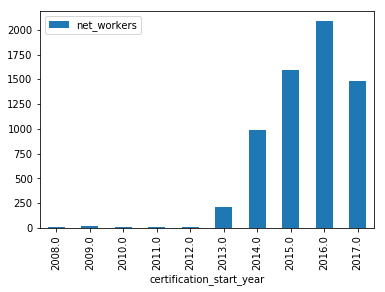

In [142]:
smvalley_crosstab.plot.bar()

In [143]:
smvalley_crosstab

,net_workers
certification_start_year,
2008.0,11.0
2009.0,16.0
2010.0,7.0
2011.0,12.0
2012.0,6.0
2013.0,210.0
2014.0,992.0
2015.0,1599.0
2016.0,2089.0


Look at the crop for those 2012 workers

In [144]:
smvalley[smvalley.certification_start_year == 2012][[
    'case_number',
    'employer',
    'city',
    'job_title',
    'crop',
    'net_workers'
]]

,case_number,employer,city,job_title,crop,net_workers
735,C-11304-30370,ST. MARTIN JAUREGUY,PASO ROBLES,"FARMWORKERS, FARM AND RANCH ANIMALS",Sheepherder,1.0
735,C-11361-31115,ST. MARTIN JAUREGUY,PASO ROBLES,SHEEPHERDER,Sheepherder,2.0
735,C-12033-32422,JEAN B JAUREGUY,PASO ROBLES,SHEEPHERDER,Sheepherder,1.0
735,C-12033-32422,ST. MARTIN JAUREGUY,PASO ROBLES,SHEEPHERDER,Sheepherder,1.0
735,C-12193-35263,JEAN B. JAUREGUY #01568,PASO ROBLES,"FARMWORKERS, FARM AND RANCH ANIMALS",Sheepherder,1.0


### Finding: Strawberry workers account for most of the growth in that area

In [145]:
smvalley_crops = smvalley[smvalley.certification_start_year == 2016].groupby([
    'latimes_crop'
]).net_workers.sum().reset_index().set_index("latimes_crop")

In [146]:
smvalley_crops.sort_values("net_workers", ascending=False).head(10)

,net_workers
latimes_crop,
Strawberries,1075.0
Lettuce,324.0
Blackberries,133.0
Celery,95.0
Other,75.0
Zucchini,73.0
Broccoli,53.0
Peppers,45.0
Squash,39.0
